In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# from pandasql import sqldf
import duckdb
from pyspark.sql import SparkSession
import statsmodels.api as sm
from pydataset import data


In [49]:
# # Load the AirPassengers dataset
# data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv", header=0, index_col=0, parse_dates=True)
# # Ensure the column name is "Passengers"
# data.columns = ['Passengers']
# data
df= pd.read_csv('AirPassengers.csv')
df.set_index('date', inplace=True)
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [50]:
df.tail()

,value
date,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [5]:
df.shape

(144, 2)

In [51]:
train_size=int(0.80*(len(df)))
train_size

115

In [52]:
train=df.iloc[:train_size]
test= df.iloc[train_size:]

In [53]:
test.shape

(29, 1)

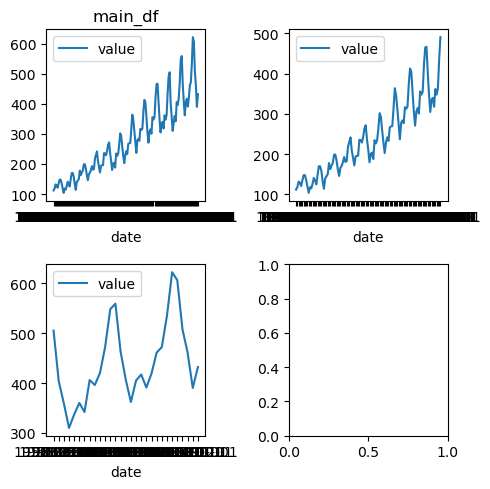

In [54]:
fig, ax= plt.subplots(2,2, figsize=(5,5))
sns.lineplot(data=df,ax=ax[0,0])
ax[0,0].set_title('main_df')
sns.lineplot(data=train, ax=ax[0,1])
sns.lineplot(data=test, ax=ax[1,0])
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Train and Test Data')

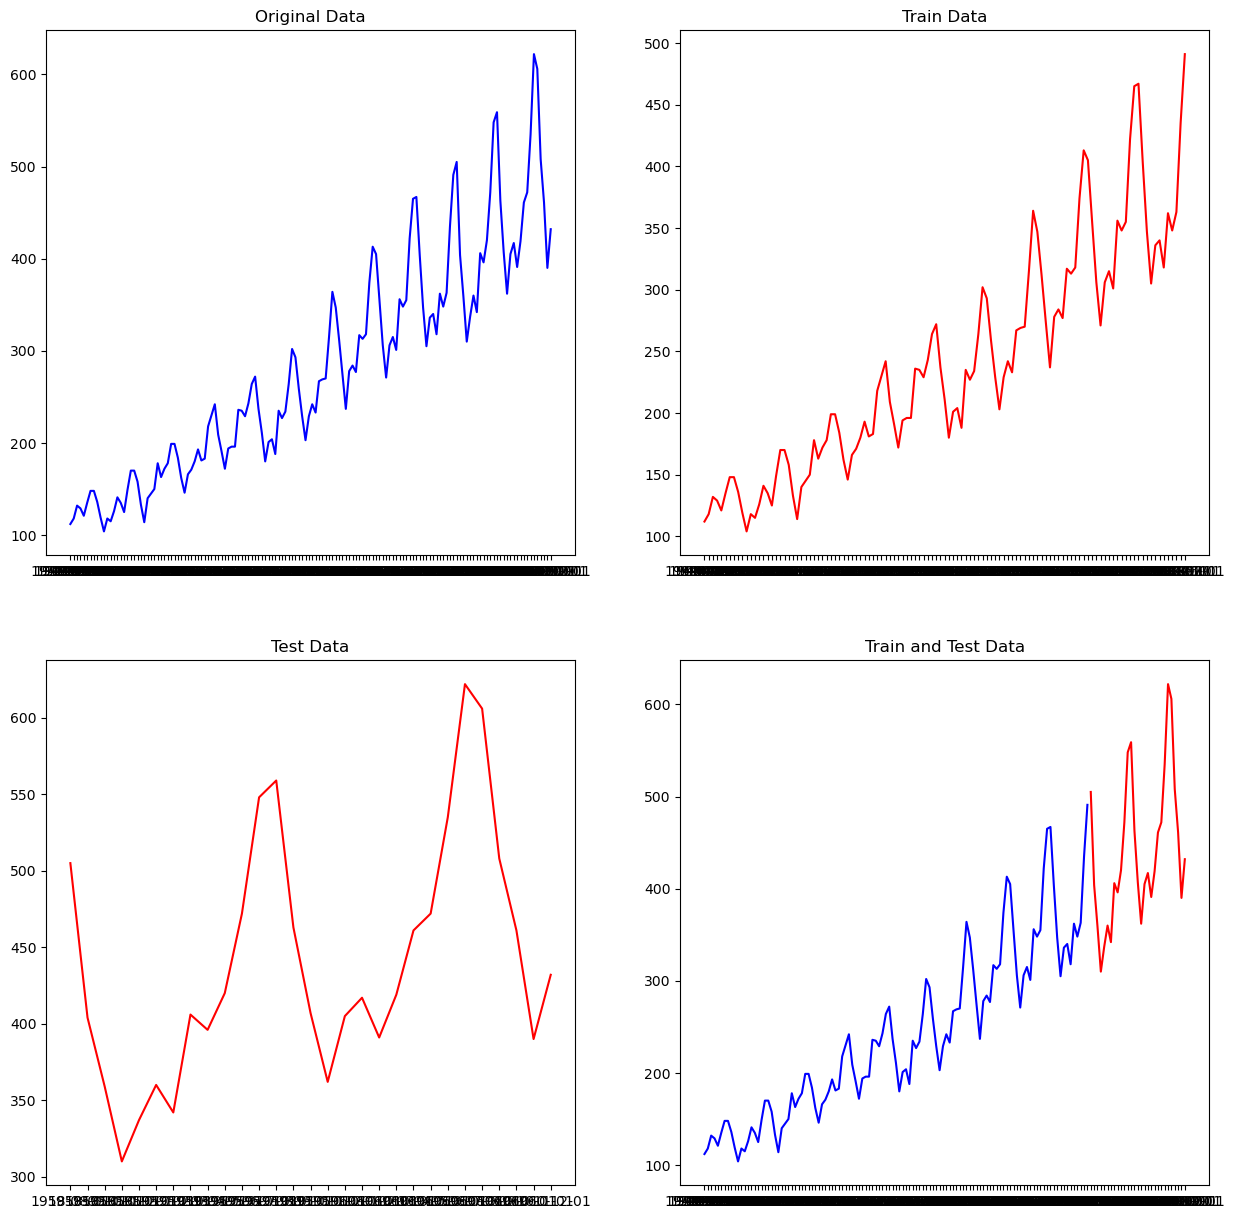

In [56]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].plot(df['value'], color='b')
ax[0,0].set_title('Original Data')
ax[0,1].plot(train['value'], color='r')
ax[0,1].set_title('Train Data')
ax[1,0].plot(test['value'], color='r')
ax[1,0].set_title('Test Data')
# ##
ax[1,1].plot(train['value'], color='b')
ax[1,1].plot(test['value'], color='r')
ax[1,1].set_title('Train and Test Data')

## Time Series modeling part

In [57]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

## AR model

/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


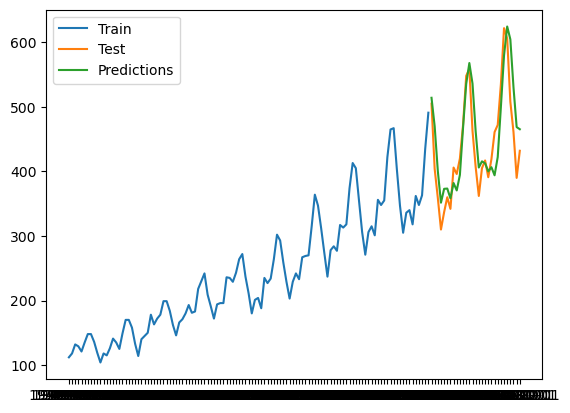

In [68]:
ar_model = AutoReg(train, lags=12)
ar_fit = ar_model.fit()
ar_predictions = ar_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# ar_mape = mean_absolute_percentage_error(test, ar_predictions)
# print("AR Model MAPE: ", ar_mape)
# ar_mse = mean_squared_error(test, ar_predictions)
# print("AR Model MSE: ", ar_mse)
# ar_rmse = np.sqrt(ar_mse)
# print("AR Model RMSE: ", ar_rmse)
# ar_mae = mean_absolute_error(test, ar_predictions)
# print("AR Model MAE: ", ar_mae)
# ar_r2 = r2_score(test, ar_predictions)
# print("AR Model R2: ", ar_r2)
# ar_r2_adj = adjusted_r2_score(test, ar_predictions)
# print("AR Model Adjusted R2: ", ar_r2_adj)
plt.plot(train.index, train['value'], label='Train')
plt.plot(test.index, test['value'], label='Test')
plt.plot(test.index, ar_predictions, label='Predictions')
plt.legend()


Forecast values:
 1957-01-01    324.855659
1957-02-01    323.341345
1957-03-01    351.272099
1957-04-01    353.206963
1957-05-01    371.465996
Freq: MS, dtype: float64
Forecast DataFrame:
             Passengers
1957-01-31         NaN
1957-02-28         NaN
1957-03-31         NaN
1957-04-30         NaN
1957-05-31         NaN


/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


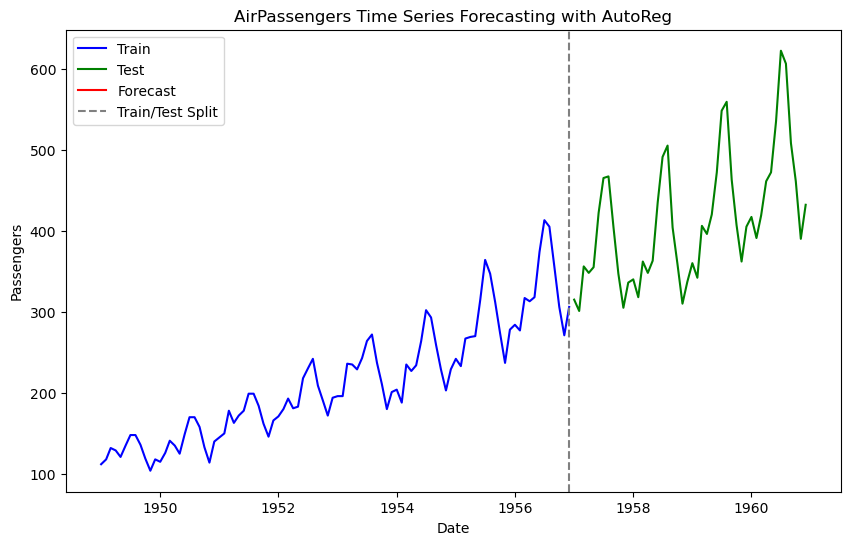

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Load the AirPassengers dataset
data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv", header=0, index_col=0, parse_dates=True)
data.columns = ['Passengers']

# Split the data into train and test sets
train_size = int(len(data) * 0.67)
train, test = data[:train_size], data[train_size:]

# Fit AutoReg model
lags = 12  # Number of lag observations included in the model
ar_model = AutoReg(train, lags=lags)
ar_fit = ar_model.fit()

# Forecast for the next 3 years (36 months)
forecast_periods = 36
ar_forecast = ar_fit.predict(start=len(train), end=len(train) + forecast_periods - 1, dynamic=False)

# Debug print to check the forecast values
print("Forecast values:\n", ar_forecast.head())

# Create a new time index for the forecast
last_train_date = train.index[-1]
forecast_index = pd.date_range(start=last_train_date, periods=forecast_periods + 1, freq='M')[1:]

# Convert the forecast into a DataFrame with the correct index
ar_forecast = pd.DataFrame(ar_forecast, index=forecast_index, columns=['Passengers'])

# Debug print to check the forecast DataFrame
print("Forecast DataFrame:\n", ar_forecast.head())

# Combine train, test, and forecast data for plotting
combined_data = pd.concat([train, ar_forecast])

# Plotting
plt.figure(figsize=(10, 6))

# Plot the actual data
plt.plot(train.index, train['Passengers'], label='Train', color='blue')
plt.plot(test.index, test['Passengers'], label='Test', color='green')
plt.plot(ar_forecast.index, ar_forecast['Passengers'], label='Forecast', color='red')

# Add vertical line for the train/test split
plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Train/Test Split')

plt.title('AirPassengers Time Series Forecasting with AutoReg')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()


## Exponential Smoothening

- 1st version

/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


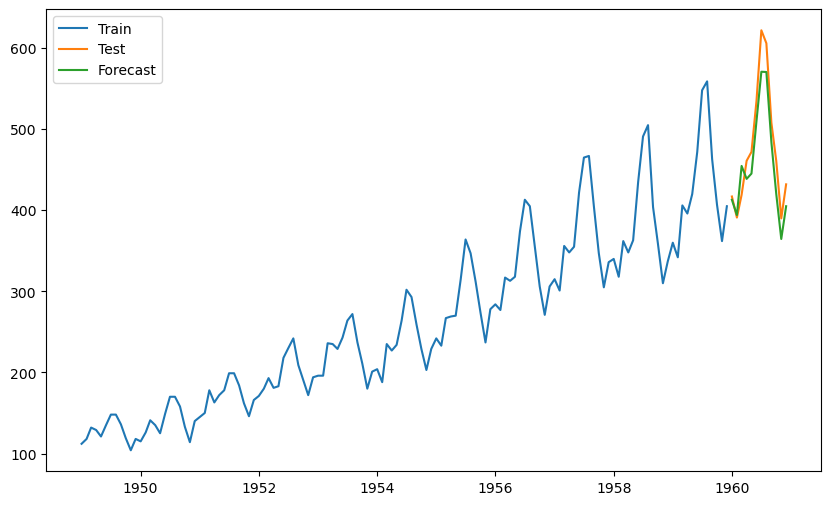

Mean Squared Error: 884.5808514487641


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]

# Fit the Exponential Smoothing model
model = ExponentialSmoothing(train_data['Passengers'], seasonal='mul', seasonal_periods=12).fit()

# Make predictions
predictions = model.forecast(len(test_data))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions, label='Forecast')
plt.legend(loc='best')
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data['Passengers'], predictions)
print(f'Mean Squared Error: {mse}')


- 2nd version

/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


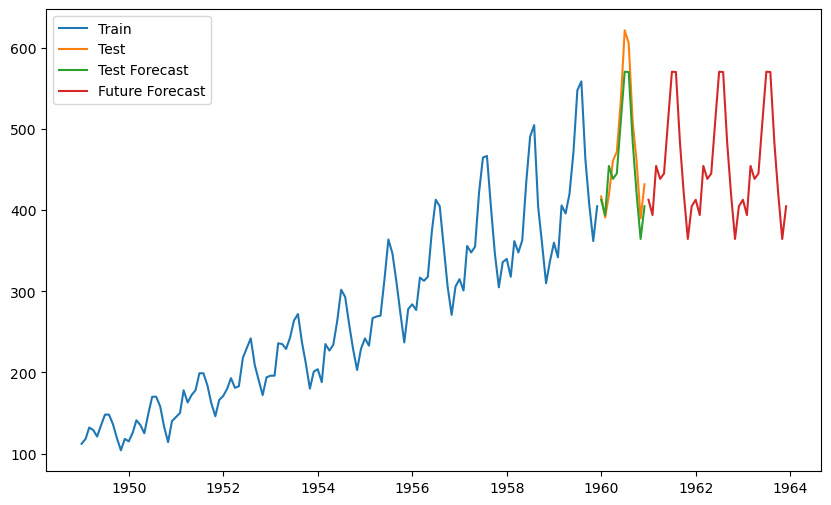

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]

# Fit the Exponential Smoothing model
model = ExponentialSmoothing(train_data['Passengers'], seasonal='mul', seasonal_periods=12).fit()

# Make predictions for the test set
predictions_test = model.forecast(len(test_data))

# Make predictions for the next 3 years (36 months)
forecast_steps = 36
forecast = model.forecast(forecast_steps)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:], forecast, label='Future Forecast')
plt.legend(loc='best')
plt.show()


# Triple Exponential smoothening 
- (Holt-Winters' Seasonal Model)

- 1. Loading the Dataset: The AirPassengers dataset is loaded from a CSV file. The parse_dates argument ensures that the 'Month' column is parsed as dates, and index_col sets 'Month' as the index of the DataFrame.

- 2 Splitting the Dataset: The dataset is split into training data (up to December 1959) and test data (from January 1960 onwards).

- 3 Fitting the Triple Exponential Smoothing Model: The ExponentialSmoothing function from statsmodels is used. Here, trend='add' specifies an additive trend component, and seasonal='mul' specifies multiplicative seasonality. The seasonal_periods=12 argument indicates a yearly seasonal period.

- 4 Making Predictions: Predictions are made for the test set, and separately, forecasts are made for the next 3 years (36 months).

- 5 Plotting the Results: The training data, test data, test set forecast, and future forecast are plotted for visual comparison.

- 6 Evaluating the Model: The Mean Squared Error (MSE) is calculated to evaluate the model's performance on the test set.

This approach uses the Triple Exponential Smoothing method, which incorporates level, trend, and seasonal components to make accurate forecasts for both the test period and future periods.

/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


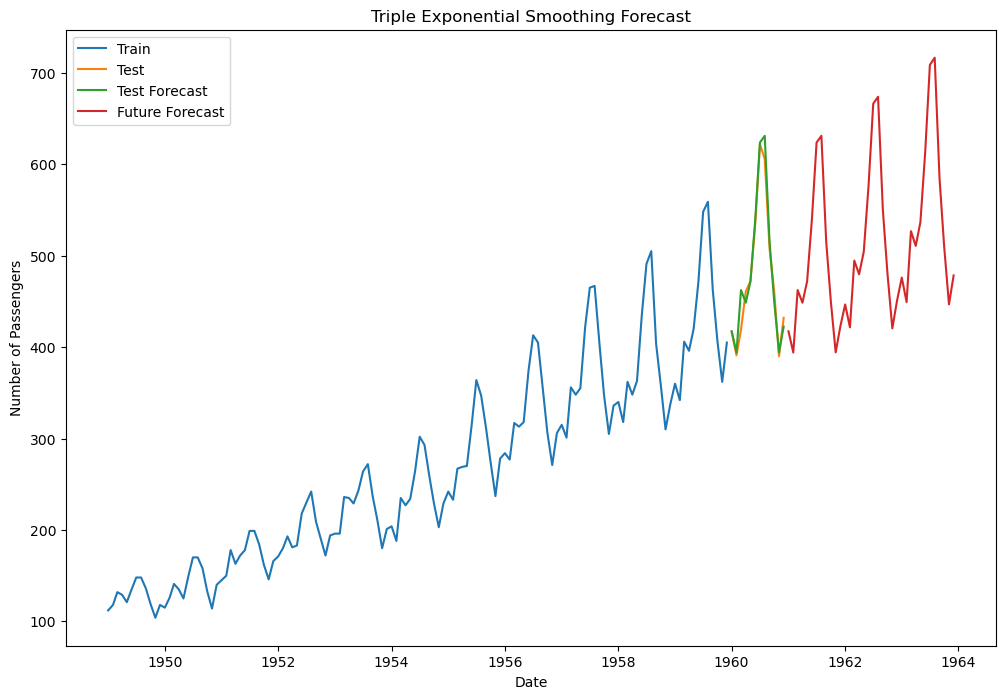

Mean Squared Error: 249.96288466661943


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]

# Fit the Triple Exponential Smoothing model (multiplicative seasonality)
model = ExponentialSmoothing(train_data['Passengers'], trend='add', seasonal='mul', seasonal_periods=12).fit()

# Make predictions for the test set
predictions_test = model.forecast(len(test_data))

# Make predictions for the next 3 years (36 months)
forecast_steps = 36
forecast = model.forecast(forecast_steps)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:], forecast, label='Future Forecast')
plt.legend(loc='best')
plt.title('Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data['Passengers'], predictions_test)
print(f'Mean Squared Error: {mse}')


# SARIMAX model
- State-Space Models

- 1 Loading the Dataset: The AirPassengers dataset is loaded from a CSV file. The parse_dates argument ensures that the 'Month' column is parsed as dates, and index_col sets 'Month' as the index of the DataFrame.

- 2 Splitting the Dataset: The dataset is split into training data (up to December 1959) and test data (from January 1960 onwards).

- 3 Fitting the SARIMA Model: The SARIMAX function from statsmodels is used to fit a SARIMA model to the training data. The order parameter specifies the (p, d, q) parameters for the non-seasonal part of the model, and the seasonal_order parameter specifies the (P, D, Q, s) parameters for the seasonal part of the model.

- (i) p: The number of lag observations included in the model (autoregressive part).
- (ii) d: The number of times that the raw observations are differenced (differencing part).
- (iii) q: The size of the moving average window (moving average part).
P, D, Q, s: The same components but for the seasonal part of the model, where s is the number of periods in a season (e.g., 12 for monthly data with a yearly seasonality).

- 4 Making Predictions: The get_forecast method is used to make predictions for the test set and future forecasts for the next 3 years (36 months).

- 5 Plotting the Results: The training data, test data, test set forecast, and future forecast are plotted for visual comparison.

- 6 Evaluating the Model: The Mean Squared Error (MSE) is calculated to evaluate the model's performance on the test set.

This code will fit a SARIMA model to the AirPassengers training data, make predictions on the test set, and forecast the number of passengers for the next 3 years.


/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39140D+00    |proj g|=  6.86568D-02

At iterate    5    f=  3.38797D+00    |proj g|=  3.03804D-02

At iterate   10    f=  3.38299D+00    |proj g|=  2.47866D-02

At iterate   15    f=  3.37783D+00    |proj g|=  4.65666D-03

At iterate   20    f=  3.37679D+00    |proj g|=  2.46420D-03

At iterate   25    f=  3.37659D+00    |proj g|=  6.98258D-04

At iterate   30    f=  3.37654D+00    |proj g|=  1.52884D-03

At iterate   35    f=  3.37652D+00    |proj g|=  2.32819D-04

At iterate   40    f=  3.37652D+00    |proj g|=  5.32443D-05

At iterate   45    f=  3.37651D+00    |proj g|=  2.58653D-04

At iterate   50    f=  3.37651D+00    |proj g|=  4.44402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


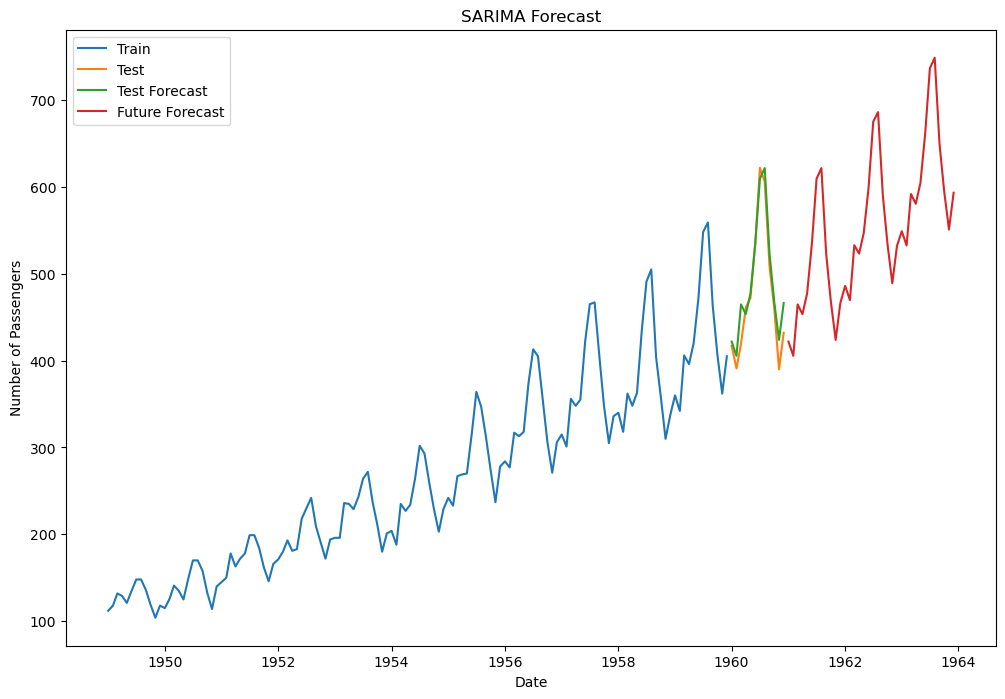

Mean Squared Error: 449.05699654211077


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]

# Fit the SARIMA model
# (p, d, q) are the non-seasonal parameters
# (P, D, Q, s) are the seasonal parameters
model = SARIMAX(train_data['Passengers'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# Make predictions for the test set
predictions_test = model.get_forecast(steps=len(test_data)).predicted_mean

# Make predictions for the next 3 years (36 months)
forecast_steps = 36
forecast = model.get_forecast(steps=forecast_steps).predicted_mean

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:], forecast, label='Future Forecast')
plt.legend(loc='best')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data['Passengers'], predictions_test)
print(f'Mean Squared Error: {mse}')


# 7. Seasonal Decomposition of Time Series (STL)


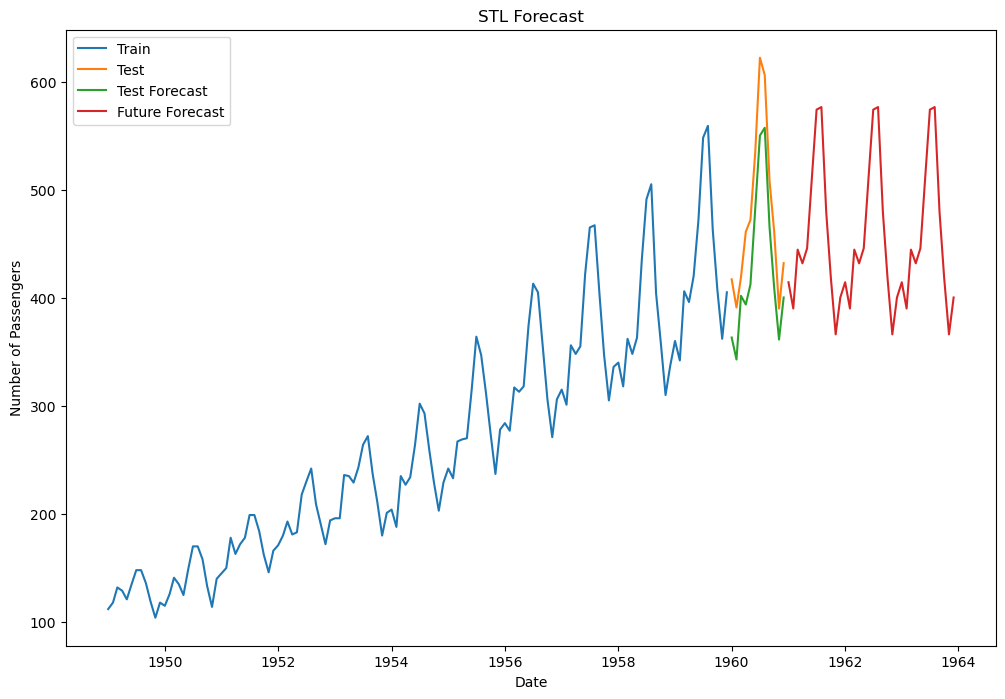

STL MSE: 2523.94758354533


In [104]:
from statsmodels.tsa.seasonal import STL
# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]

# Fit the STL model
stl = STL(train_data['Passengers'], seasonal=13)
result = stl.fit()
seasonal, trend = result.seasonal, result.trend

# Predict by adding the trend and seasonal components
predictions_test = trend[-len(test_data):] + seasonal[-len(test_data):]

# Forecast the next 3 years (36 months)
forecast_steps = 36
forecast_trend = np.array([trend[-1]] * forecast_steps)
forecast_seasonal = np.tile(seasonal[-12:], 3)
forecast = forecast_trend + forecast_seasonal

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:], forecast, label='Future Forecast')
plt.legend(loc='best')
plt.title('STL Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data['Passengers'], predictions_test)
print(f'STL MSE: {mse}')


# Unobserved Components Models (UCM)


/Users/zeeshan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61047D+00    |proj g|=  7.58261D-03

At iterate    5    f=  4.05786D+00    |proj g|=  2.64563D-02

At iterate   10    f=  3.80089D+00    |proj g|=  6.02292D-04

At iterate   15    f=  3.80087D+00    |proj g|=  2.41458D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     31      1     0     0   4.796D-06   3.801D+00
  F =   3.8008703902146537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


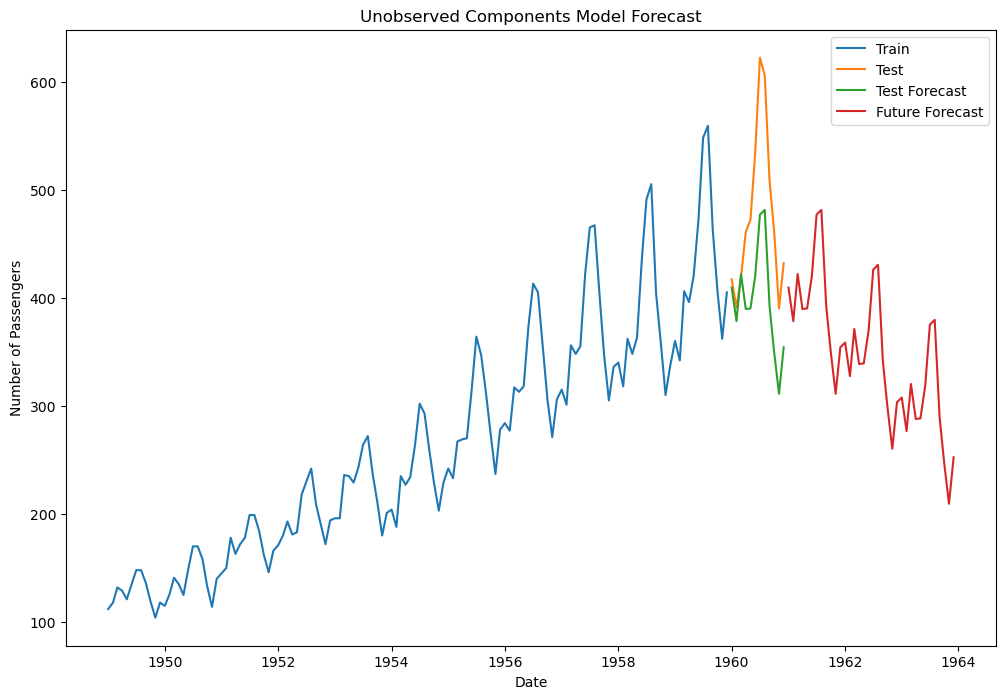

Mean Squared Error: 8333.315619018538


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_squared_error

# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]

# Fit the Unobserved Components Model (UCM)
# Add trend and seasonal components to the model
model = UnobservedComponents(train_data['Passengers'], level='local linear trend', seasonal=12).fit()

# Make predictions for the test set
predictions_test = model.get_forecast(steps=len(test_data)).predicted_mean

# Make predictions for the next 3 years (36 months)
forecast_steps = 36
forecast = model.get_forecast(steps=forecast_steps).predicted_mean

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:], forecast, label='Future Forecast')
plt.legend(loc='best')
plt.title('Unobserved Components Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data['Passengers'], predictions_test)
print(f'Mean Squared Error: {mse}')


# ML models

## XGBoost

/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_56230/525883006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Month'] = train_data.index.month
/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_56230/525883006.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Year'] = train_data.index.year
/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_56230/525883006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

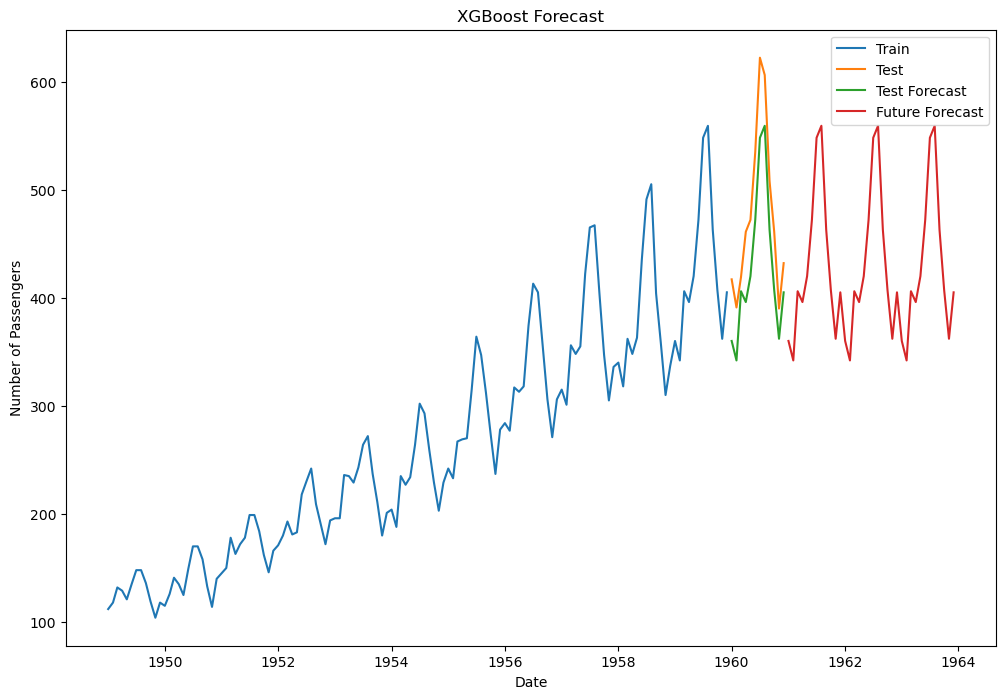

XGBoost MSE: 2571.2821262493576


In [108]:
import xgboost as xgb

# Prepare the data for XGBoost
train_data['Month'] = train_data.index.month
train_data['Year'] = train_data.index.year
test_data['Month'] = test_data.index.month
test_data['Year'] = test_data.index.year

X_train = train_data[['Month', 'Year']]
y_train = train_data['Passengers']
X_test = test_data[['Month', 'Year']]
y_test = test_data['Passengers']

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Make predictions for the test set
predictions_test = model.predict(X_test)

# Make predictions for the next 3 years (36 months)
future_dates = pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:]
future_df = pd.DataFrame({'Month': future_dates.month, 'Year': future_dates.year})
forecast = model.predict(future_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(future_dates, forecast, label='Future Forecast')
plt.legend(loc='best')
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, predictions_test)
print(f'XGBoost MSE: {mse}')


# Random Forest

/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_56230/2497736269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Month'] = train_data.index.month
/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_56230/2497736269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Year'] = train_data.index.year
/var/folders/hr/rf0dchj10b12tqdvgfmnxw_h0000gp/T/ipykernel_56230/2497736269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

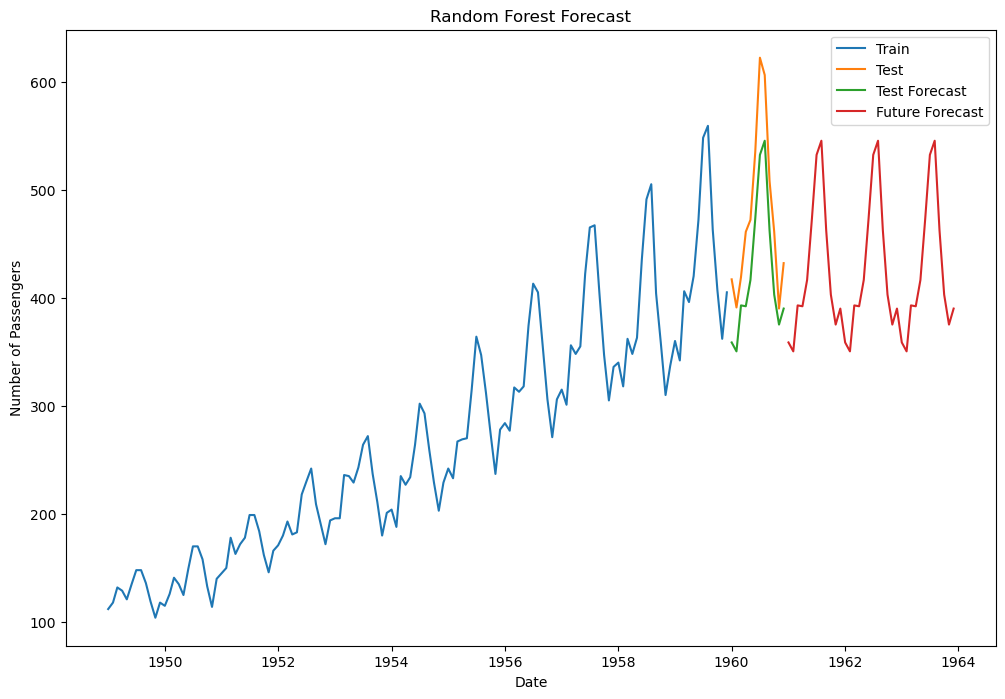

Random Forest MSE: 3051.433825


In [110]:
from sklearn.ensemble import RandomForestRegressor

# Prepare the data for Random Forest
train_data['Month'] = train_data.index.month
train_data['Year'] = train_data.index.year
test_data['Month'] = test_data.index.month
test_data['Year'] = test_data.index.year

X_train = train_data[['Month', 'Year']]
y_train = train_data['Passengers']
X_test = test_data[['Month', 'Year']]
y_test = test_data['Passengers']

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions for the test set
predictions_test = model.predict(X_test)

# Make predictions for the next 3 years (36 months)
future_dates = pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:]
future_df = pd.DataFrame({'Month': future_dates.month, 'Year': future_dates.year})
forecast = model.predict(future_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(future_dates, forecast, label='Future Forecast')
plt.legend(loc='best')
plt.title('Random Forest Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, predictions_test)
print(f'Random Forest MSE: {mse}')


# Prophet

In [102]:
from prophet import Prophet
# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]
# Prepare the data for Prophet
train_prophet = train_data.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})

# Fit the Prophet model
model = Prophet()
model.fit(train_prophet)

# Make predictions for the test set
future_test = model.make_future_dataframe(periods=len(test_data), freq='M')
forecast_test = model.predict(future_test)
predictions_test = forecast_test['yhat'][-len(test_data):].values

# Make predictions for the next 3 years (36 months)
future_forecast = model.make_future_dataframe(periods=forecast_steps, freq='M')
forecast = model.predict(future_forecast)
future_predictions = forecast['yhat'][-forecast_steps:].values

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predictions_test, label='Test Forecast')
plt.plot(pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:], future_predictions, label='Future Forecast')
plt.legend(loc='best')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data['Passengers'], predictions_test)
print(f'Prophet MSE: {mse}')


TypeError: This is a python-holidays entity loader class. For entity inheritance purposes please import a class you want to derive from directly: e.g., `from holidays.countries import Entity` or `from holidays.financial import Entity`.

## LSTM Model

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Split the dataset into train and test sets
train_data = data[:'1959']
test_data = data['1960':]

# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

train_scaled = scaled_data[:len(train_data)]
test_scaled = scaled_data[len(train_data):]

X_train, y_train = [], []
for i in range(12, len(train_scaled)):
    X_train.append(train_scaled[i-12:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
inputs = np.concatenate((train_scaled[-12:], test_scaled), axis=0)
X_test = []
for i in range(12, len(inputs)):
    X_test.append(inputs[i-12:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions for the test set
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Make predictions for the next 3 years (36 months)
forecast_steps = 36
future_inputs = inputs[-12:]
future_predictions = []
for i in range(forecast_steps):
    future_input = future_inputs[-12:].reshape(1, -1, 1)
    future_pred = model.predict(future_input)
    future_predictions.append(future_pred[0, 0])
    future_inputs = np.append(future_inputs, future_pred)[-12:]

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data['Passengers'], label='Train')
plt.plot(test_data.index, test_data['Passengers'], label='Test')
plt.plot(test_data.index, predicted_test, label='Test Forecast')
plt.plot(pd.date_range(start=test_data.index[-1], periods=forecast_steps + 1, freq='MS')[1:], future_predictions, label='Future Forecast')
plt.legend(loc='best')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data['Passengers'], predicted_test)
print(f'LSTM MSE: {mse}')


TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates